In [146]:
### Settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
import matplotlib.dates as mdates
import glob

%matplotlib inline

# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 3)

In [147]:
### Read data

#df = pd.read_csv('turnstile_170107.txt')

frames = []
for filename in glob.glob("turnstile_16*.txt"): # glob() finds every file in the directory matching a pattern
    frames.append(pd.read_csv(filename))   # make list of dataframes
df = pd.concat(frames)                    # concatenate all dataframes

In [157]:
### Clean data

df.columns = [n.lower().strip() for n in list(df)]
df['dt'] = df.date.str.cat(df.time, sep=' ')
df.dt = df.dt.apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y %H:%M:%S'))
df['traffic'] = df.entries + df.exits
print df.columns # Check list of columns
print df.dt.describe() # Check first and last datetimes


Index([u'c/a', u'unit', u'scp', u'station', u'linename', u'division', u'date',
       u'time', u'desc', u'entries', u'exits', u'dt', u'traffic'],
      dtype='object')
count                  776016
unique                  47072
top       2016-06-24 00:00:00
freq                     2406
first     2016-05-28 00:00:00
last      2016-06-24 23:59:42
Name: dt, dtype: object


In [149]:
### Look at all the different stations
# Note that some groupings are wrong:
# 125 ST on the 1, the 2/3, and the 4/5/6 are indeed separate stations, but...
# 14 ST-UNION SQ, 456LNQRW and 14 ST-UNION SQ, LNQR456W are really the same thing.
# But for now we'll use these groupings.

groups = df.groupby(['station', 'linename']).groups.keys()
groups.sort()
print pd.Series(groups) # Turn this list into a Series so it prints nicely

0                           (1 AV, L)
1                         (103 ST, 1)
2                         (103 ST, 6)
3                        (103 ST, BC)
4                  (103 ST-CORONA, 7)
5                         (104 ST, A)
6                        (104 ST, JZ)
7                         (110 ST, 6)
8                         (111 ST, 7)
9                         (111 ST, A)
10                        (111 ST, J)
11                       (116 ST, 23)
12                        (116 ST, 6)
13                       (116 ST, BC)
14               (116 ST-COLUMBIA, 1)
15                       (121 ST, JZ)
16                        (125 ST, 1)
17                       (125 ST, 23)
18                      (125 ST, 456)
19                     (125 ST, ACBD)
20                       (135 ST, 23)
21                       (135 ST, BC)
22               (137 ST CITY COL, 1)
23               (138/GRAND CONC, 45)
24                    (14 ST, 123FLM)
25                      (14 ST, ACEL)
26          

station  linename  dt        
14 ST    123FLM    2016-05-28    21605986143
                   2016-05-29    18554838986
                   2016-05-30    18554941640
                   2016-05-31    18555062925
                   2016-06-01    18555238891
                   2016-06-02    18555430526
                   2016-06-03    18555626098
                   2016-06-04    18555801469
                   2016-06-05    18542878661
                   2016-06-06    18556089538
                   2016-06-07    18556278797
                   2016-06-08    21607919428
                   2016-06-09    18556660217
                   2016-06-10    18556854252
                   2016-06-11    18557030027
                   2016-06-12    18557167437
                   2016-06-13    18550045577
                   2016-06-14    18557488360
                   2016-06-15    18557677713
                   2016-06-16    18557872738
                   2016-06-17    18558066265
                   2016-0

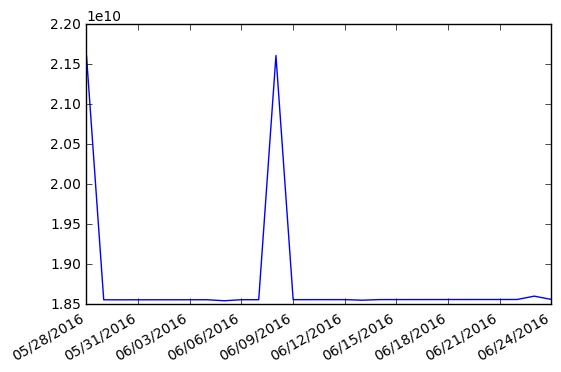

In [204]:
### Try plotting data for one station, grouped by day

test = df[(df.station == '14 ST') & (df.linename == '123FLM')]
test.index = test.dt # Saves datetime as the Index for easy plotting

grouped = test.groupby(['station', 'linename'])  # Group by station
grouped_day = grouped.traffic.resample('D').sum() # Resample Traffic by Day and sums the values
print grouped_day  # Shows our aggregated data
grouped_day.index = grouped_day.index.get_level_values('dt') # Fix the Index

# Alternate method - we could also aggregate by group and then aggregate by day:
# grouped = test.groupby(['station', 'linename', 'dt'], as_index = False).agg({'traffic':np.sum})
# grouped.index = grouped.dt # Saves datetime as the Index for easy plotting
# grouped_day = grouped.traffic.resample('D').sum() # This sums all rows that belong to the same Day

# Plotting things
# Most of this stuff is for formatting.
# You could simply run 'plt.plot(grouped_day)' to get almost the same thing
fig, ax = plt.subplots()
ax.plot(grouped_day)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
ax.get_yaxis().get_major_formatter().set_useOffset(False)
fig.autofmt_xdate()

# Yes, the scale of the y-axis is dumb. Will fix it later.

station  linename  dt        
14 ST    123FLM    2016-05-29     40160825129
                   2016-06-05    129874980210
                   2016-06-12    132947999696
                   2016-06-19    129897778510
                   2016-06-26     92835849230
Name: traffic, dtype: int64


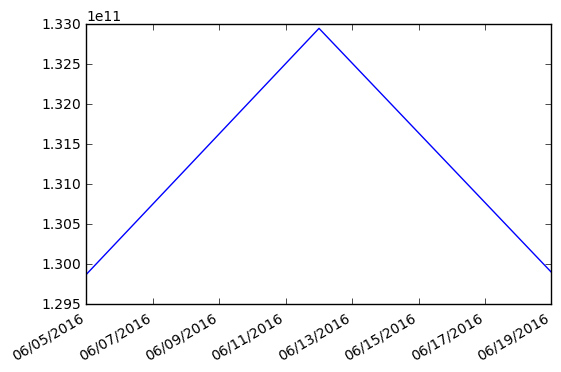

In [200]:
### Try grouping by week

grouped_week = grouped.traffic.resample('W').sum()
print grouped_week
grouped_week.index = grouped_week.index.get_level_values('dt') # Fix the Index


# Plotting
fig, ax = plt.subplots()
ax.plot(grouped_week[1:4])  # 6/05 through 6/19 are the only complete weeks in this data set
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
ax.get_yaxis().get_major_formatter().set_useOffset(False)
fig.autofmt_xdate()

In [209]:
### Note: some stations have many more data points than others (they are sampled more frequently)

df.groupby(['station', 'linename', 'dt'], as_index = False).agg({'traffic':np.sum}). \
    groupby(['station','linename']).size()

station          linename   
1 AV             L               174
103 ST           1               171
                 6               171
                 BC              170
103 ST-CORONA    7               169
104 ST           A               169
                 JZ              168
110 ST           6               178
111 ST           7               169
                 A               170
                 J               169
116 ST           23              172
                 6               169
                 BC              169
116 ST-COLUMBIA  1               172
121 ST           JZ              168
125 ST           1               172
                 23              173
                 456             170
                 ACBD            172
135 ST           23              168
                 BC              171
137 ST CITY COL  1               170
138/GRAND CONC   45              169
14 ST            123FLM          171
                 ACEL            169
         

In [208]:
### For example, 14TH ST on the 1 is sampled a lot!

df[df.station == '14TH STREET'].groupby(['station', 'linename', 'dt']).size()

station      linename  dt                 
14TH STREET  1         2016-05-28 00:21:53    1
                       2016-05-28 00:39:58    1
                       2016-05-28 01:12:13    1
                       2016-05-28 02:06:00    1
                       2016-05-28 02:15:53    1
                       2016-05-28 02:18:18    1
                       2016-05-28 03:02:49    1
                       2016-05-28 03:04:10    1
                       2016-05-28 03:19:02    1
                       2016-05-28 03:19:45    1
                       2016-05-28 04:11:33    1
                       2016-05-28 04:33:53    1
                       2016-05-28 04:51:58    1
                       2016-05-28 05:24:13    1
                       2016-05-28 06:18:00    1
                       2016-05-28 06:27:53    1
                       2016-05-28 06:30:18    1
                       2016-05-28 07:14:49    1
                       2016-05-28 07:16:10    1
                       2016-05-28 07:31:02   

In [202]:
### Which stations have the most traffic in this entire time period?

df.groupby(['station', 'linename'], as_index = False).agg({'traffic':np.sum}). \
    sort_values('traffic', ascending=False)


,station,linename,traffic
103,42 ST-PORT AUTH,ACENQRS1237,2440527777384
121,57 ST-7 AV,NQR,2325630172397
233,CANAL ST,JNQRZ6,1803557830650
443,TIMES SQ-42 ST,1237ACENQRS,1736907440482
90,34 ST-HERALD SQ,BDFMNQR,1102892584258
74,23 ST,FM,1068077868561
17,125 ST,23,1032001919695
72,23 ST,6,976233382768
139,72 ST,123,972987644743
301,FULTON ST,ACJZ2345,883325451145
